## Super Resolution via Sparse-Representation

### Part 1 :  Learning dictionary

List of variables :

n = 1024 # Dico size

m = # size of pic

Dh = Dico high resolution (n*m)

Dl = Dico low resolution (n*m)

Xh = High resolution Im

Yl = Low resolution Im

Xc = Fx(Xh,Yl)

Dc = Fd(Dh,Dl)

Function that we will need later on

decomposition.NMF([n_components, init, ...])	#Non-Negative Matrix Factorization (NMF)

In [35]:
# Importation of package
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageChops #to trim pic
#from resizeimage import resizeimage #to resize pic
%matplotlib inline
import random
import math
import time
#from skimage.util.shape import view_as_windows #to patches picture
#from skimage.util.montage import montage2d #to see patches

from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

# from cvxopt import matrix, solvers#to solve optimisation probleme
from scipy.optimize import minimize, fmin

(671, 447)

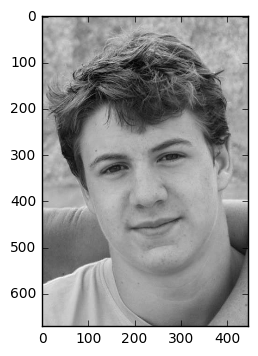

In [4]:
# Loading the picture
path = './'
img = cv2.imread(path+'/hugo.jpg',0)
plt.imshow(img, cmap = 'gray')
img.shape

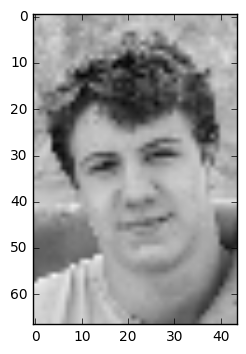

In [5]:
# Loading high and low resolution picture

Xh = img
height, width = Xh.shape
Yl = cv2.resize(img, (width/10,height/10), interpolation = cv2.INTER_CUBIC)
plt.imshow(Yl, cmap = 'gray')

In [6]:
# Necessary function to go further

# This function create a gaussian random matrix, with column unit normalized
def Creation_Matrix(nbx,nby) :
    M = [[random.normalvariate(0, 1) for i in range(nby)] for j in range(nbx)]
    S = np.sum(M, axis = 0)
    M = M /S
    return (M)

In [7]:
# THINGS TO DO : 
# - manage with the max_patches

# Dictionary training

# Step 0 : Initialisation 

n_D = 256 # Dict size
h_h, w_h = Xh.shape
h_l, w_l = Xh.shape
patch_size = (1, 1)
lam = 0.1

# Creation of the patches hight r picture
Xh_p = extract_patches_2d(Xh, patch_size, max_patches= 2000 )
N = Xh_p.shape[0]*Xh_p.shape[1]*Xh_p.shape[2]
Xh_p = Xh_p.reshape( N, 1)

# Creation of the patches low r picture
Yl = cv2.resize(Xh, (width/10,height/10), interpolation = cv2.INTER_CUBIC)
Yl_p =  extract_patches_2d(Yl, patch_size,  max_patches= 2000)
M = Yl_p.shape[0]*Yl_p.shape[1]*Yl_p.shape[2]
Yl_p = Yl_p.reshape( M , 1)

Xc = np.concatenate((Xh_p/math.sqrt(Xh_p.shape[0]), Yl_p/math.sqrt(Yl_p.shape[0])), axis=0)

Z0 = np.array(np.random.normal(size = n_D))
print Xc.shape, Z0.shape

(4000, 1) (256,)


In [15]:
# Step 1 : initialisation of our dico D with a gaussian random matrix, column unit normalized
D = Creation_Matrix(Xc.shape[0], n_D)
D.shape

(4000, 256)

In [16]:
# Step 2 : Fix D and update Z (First optimisation (18))
# Z is coming from n linear programing optimisation

fun = lambda Z: (sum((Xc-np.dot(D,Z))**2) + lam*abs(sum(Z)))[0]
res = fmin(fun, Z0, maxiter = 50 ) # bounds = ?  # VERY LONG AND NOT VERY GREAT
Z = res

In [19]:
# Step 3 : Fix Z and update D (Second Optimisation (19))
# According to the paper ref [22] " Efficient sparse coding algorithm" we can solve the second optimisation with a Lagragian methode
Lambda = np.diag(np.repeat(0.1,n_D)) # Lagragian parameter, can be modify
D = np.dot(np.linalg.inv(Z*np.transpose(Z)+ Lambda),np.transpose(Xc*np.transpose(Z)))
D = np.transpose(D)

We've done the compilation step by step now, let's runing it until convergence !

In [40]:
# Input and initialization
D0 = Creation_Matrix(Xc.shape[0], n_D)
Z0 = np.array(np.random.normal(size = n_D))
#Xc = np.concatenate((Xh_p/math.sqrt(Xh_p.shape[0]), Yl_p/math.sqrt(Yl_p.shape[0])), axis=0)

i=1
maxiter = 10
epsilon = 10^-3
# While 
while i<maxiter and Z_err>epsilon and D_err>epsilon: 
    start_time = time.time()
    # Fix D and update Z
    fun = lambda Z: (sum((Xc-np.dot(D0,Z))**2) + lam*abs(sum(Z)))[0]
    Z = fmin(fun, Z0, maxiter = 20 )
    Z_err = sum(abs(Z-Z0))
    # Fix Z and update D
    D = np.dot(np.linalg.inv(Z*np.transpose(Z)+ Lambda),np.transpose(Xc*np.transpose(Z)))
    D = np.transpose(D)
    D_err = sum(sum(abs(D-D0)))
    
    Z0 = Z
    D0 = D
    print(i)
    print("--- %s seconds ---" % (time.time() - start_time))
    i=i+1

1
--- 34.5651688576 seconds ---
2
--- 34.7179250717 seconds ---
3
--- 34.3542079926 seconds ---
4
--- 35.0378131866 seconds ---
5
--- 35.6636390686 seconds ---
6
--- 36.2637999058 seconds ---
7
--- 36.1877760887 seconds ---
8
--- 36.1077728271 seconds ---
9
--- 34.5573678017 seconds ---


In [57]:
# Creation of D_h and D_l, the both dictionnary
D_h = D[0:N]/math.sqrt(N)
D_l = D[0:M]/math.sqrt(M)
print D_h.shape
print D_l.shape

(2000, 256)
(2000, 256)


### Part 2 : Generic image

In [58]:
patch_size = (3, 3)
h, w = Yl.shape
data = extract_patches_2d(Yl, patch_size, max_patches =(h/3)*(w/3)  )
print data.shape
n_patch = data.shape[0]
data = data.reshape(data.shape[0], -1) 

## Calculate the optimization (8)
#### Create the matrix P and F. 


(308, 3, 3)


### Part Z : Additive Code

(308, 3, 3)
(308, 9)


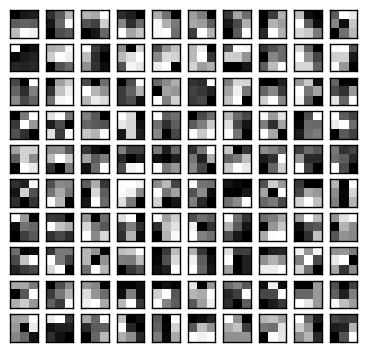

In [20]:
# To see how does the patch looks like

patch_size = (3, 3)
h, w = Yl.shape
data = extract_patches_2d(Yl, patch_size, max_patches =(h/3)*(w/3)  ) # input (array, shape = (n_patches, patch_height, patch_width))
print data.shape
n_patch = data.shape[0]
data = data.reshape(data.shape[0], -1) 
print data.shape
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(data):
    plt.subplot(10,10, i+1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    if i == 100-1 : break
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

In [14]:
# Shitty codes ----------------

patch_size = (7, 7)
data = extract_patches_2d(Yl, patch_size)
print(data.shape)
data = data.reshape(data.shape[0], -1)
h_l, w_l = Xh.shape
plt.figure(figsize=B.shape[0:2])
i = 0
for i, b in enumerate(B):
    plt.subplot(5, 5, i + 1)
    plt.imshow(b[i].reshape(window_shape), cmap=plt.cm.gray,interpolation='nearest')
    plt.xticks(())
    plt.yticks(())


#plt.suptitle('Patches of faces\nTrain time %.1fs on %d patches' %
#(dt, 8 * len(faces.images)), fontsize=16)
#plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

patch_size = (1, 1)
h, w = Yl.shape
data = extract_patches_2d(Yl, patch_size, max_patches = (h/3)*(w/3)) # input (array, shape = (n_patches, patch_height, patch_width))
n_patch = data.shape[0]
print data

data = data.reshape( data.shape[0]*data.shape[1]*data.shape[2], 1)

print data


(2318, 7, 7)


NameError: name 'B' is not defined